# Table of Contents

- [I. Import libraries](#I)
- [II. Import data](#II)
  - [1. Download data](#II.1)
  - [2. Import data](#II.2)
- [III. Exploratory Data Analysis](#III)
  - [1. Data cleaning and imputation](#III.1)
    - [a. Column type conversion](#III.1.a)
    - [b. Drop duplicates](#III.1.b)
    - [c. Drop redundant columns](#III.1.c)
    - [d. Remove transactions with TOTAL_TURNOVER = 0](#III.1.d)
    - [e. Missing value imputation](#III.1.e)
    - [f. Create RACING_TURNOVER, SPORT_TURNOVER, FOB_TURNOVER, PARI_TURNOVER columns](#III.1.f)
  - [2. Turnover](#III.2)
    - [a. RACING vs SPORT and FOB vs PARI](#III.2.a)
    - [b. Trends](#III.2.b)
      - [Aggregate](#III.2.b.1)
      - [2021 vs 2022 trend](#III.2.b.2)
      - [Racing vs Sport](#III.2.b.3)
      - [Average ticket value](#III.2.b.4)
      - [Average daily turnover per customer](#III.2.b.5)
    - [c. Correlation with other factors](#III.2.c)
      - [Correlation matrix](#III.2.c.1)
      - [Dividends paid / total turnover](#III.2.c.2)
      - [FOB vs PARI](#III.2.c.3)
  - [3. Customer](#III.3)
    - [a. General info](#III.3.a)
      - [Describe](#III.3.a.1)
      - [Unique customers](#III.3.a.2)
      - [Daily unique customers](#III.3.a.3)
      - [New customers](#III.3.a.4)
    - [b. Demographic info](#III.3.b)
      - [Gender](#III.3.b.1)
      - [Residential state](#III.3.b.2)
      - [Age](#III.3.b.3)
      - [Tenure in days](#III.3.b.4)
    - [c. Numerical data](#III.3.c)
      - [Correlation matrix](#III.3.c.1)
      - [Turnover](#III.3.c.2)
      - [Frequency vs Turnover](#III.3.c.3)
      - [Tickets vs Turnover](#III.3.c.4)
      - [Dividends, Margins vs Turnover](#III.3.c.5)

# I. Import libraries <a name="I"></a>

In [5]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go

import os
import warnings

In [6]:
# Turn off warnings
warnings.filterwarnings("ignore")

# Limit the decimal notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the theme for matplotlib figure
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# II. Import data <a name="II"></a>

## 1. Download data <a name="II.1"></a>

In [7]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

# Run the download.ipynb file
%run download.ipynb

## 2. Import data  <a name="II.2"></a>

In [8]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

# Import csv file and preview
df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


Our primary data source is (anonymized) internal wagering data from TAB: 
we have data that aggregates daily betting totals for each individual 
customer across 2021 and 2022.

Each row of this dataset represents the bets made by one customer on a 
given day spanning from 2021-01-01 to 2022-12-31. There is a unique customer identifying number, customer 
attributes and then a breakdown of the customers betting pattern for that 
day. Because of the sheer number of bets made on the platform, we are 
using data that has been aggregated daily rather than including one 
separate row for each bet made by each customer.

| Column | Description |
|-----------------|-----------------|
| DATE_DIM | Date of the transaction |
| DAY_OF_WEEK | Day name of the week of the transaction | 
| BET_ACCOUNT_NUM_HASH | Customer unique identifier | 
| AGE | Customer’s age as of Wager date | 
| AGE_BAND | Customer’s age band as of Wager date | 
| GENDER | Customer’s gender (M, F, U) | 
| TENURE_IN_DAYS | Number of days since Customer opened account as of Wager date | 
| RESIDENTIAL_STATE | Residential state where the customer resides | 
| FOB_RACING_TURNOVER | Total Bet amount spent on Fixed-odds Racing events | 
| FOB_SPORT_TURNOVER | Total Bet amount spent on Fixed-odds Sports events | 
| PARI_RACING_TURNOVER | Total Bet amount spent on Pari-mutuel Racing betting | 
| PARI_SPORT_TURNOVER | Total Bet amount spent on Pari-mutuel Sports betting | 
| TOTAL_TURNOVER | Total Bet Amount spent on the day | 
| DIVIDENDS_PAID | Total Dividend Amount won by the customer | 
| GROSS_MARGIN | Gross Margin for the Wagering provider (Turnover – Dividends - Other Costs) | 
| TICKETS | Total tickets bought by the customer on the day | 

# III. Exploratory Data Analysis  <a name="III"></a>

We are focusing on customer and turnover analysis.

## 1. Data cleaning and imputation <a name="III.1"></a>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12364101 entries, 0 to 12364100
Data columns (total 16 columns):
 #   Column                Dtype  
---  ------                -----  
 0   DATE_DIM              object 
 1   DAY_OF_WEEK           object 
 2   BET_ACCOUNT_NUM_HASH  int64  
 3   AGE                   float64
 4   AGE_BAND              object 
 5   GENDER                object 
 6   TENURE_IN_DAYS        int64  
 7   RESIDENTIAL_STATE     object 
 8   FOB_RACING_TURNOVER   float64
 9   FOB_SPORT_TURNOVER    float64
 10  PARI_RACING_TURNOVER  float64
 11  PARI_SPORT_TURNOVER   float64
 12  TOTAL_TURNOVER        float64
 13  DIVIDENDS_PAID        float64
 14  GROSS_MARGIN          float64
 15  TICKETS               int64  
dtypes: float64(8), int64(3), object(5)
memory usage: 1.5+ GB


### a. Column type conversion <a name="III.1.a"></a>

For convenience, we convert `DATE_DIM` column into datetime type and `BET_ACCOUNT_NUM_HASH` column into string type.

In [10]:
# DATE_DIM: convert into datetime
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

# BET_ACCOUNT_NUM_HASH: convert into string
df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

### b. Drop duplicates <a name="III.1.b"></a>

Remove duplicates if there are any.

In [11]:
df.drop_duplicates(inplace=True)

### c. Drop redundant columns <a name="III.1.c"></a>

`DAY_OF_WEEK` can be derived from the `DATE_DIM` column, therefore it is not necessary to keep.

In [12]:
df.drop('DAY_OF_WEEK', axis=1, inplace=True)

### d. Remove transactions with TOTAL_TURNOVER = 0 <a name="III.1.d"></a>

We are only taking transactions with `TOTAL_TURNOVER` over zero.

In [13]:
df = df[df["TOTAL_TURNOVER"] > 0]

### e. Missing value imputation <a name="III.1.b"></e>

2676 records are missing on `AGE` column. Nan values on `TURNOVER` columns indicate zero value. We decide to use mean age value to fill the missing values as the missing proportion is minimal

In [14]:
# No of missing values by column
df.isna().sum()

DATE_DIM                       0
BET_ACCOUNT_NUM_HASH           0
AGE                         2669
AGE_BAND                       0
GENDER                         0
TENURE_IN_DAYS                 0
RESIDENTIAL_STATE              0
FOB_RACING_TURNOVER      3773146
FOB_SPORT_TURNOVER      10549527
PARI_RACING_TURNOVER     3800973
PARI_SPORT_TURNOVER     12305088
TOTAL_TURNOVER                 0
DIVIDENDS_PAID                 0
GROSS_MARGIN                   0
TICKETS                        0
dtype: int64

In [15]:
# Impute age column
age_mean = df.groupby('BET_ACCOUNT_NUM_HASH').AGE.min().mean() # 44

df['AGE'].fillna(age_mean, inplace=True)

### f) Create RACING_TURNOVER, SPORT_TURNOVER, FOB_TURNOVER, PARI_TURNOVER columns <a name="III.1.f"></a>

We are going to explore different categories of wagering (`RACING_TURNOVER` + `SPORT_TURNOVER` = `FOB_TURNOVER` + `PARI_TURNOVER` = `TOTAL_TURNOVER`)

In [16]:
df['FOB_TURNOVER'] = df[['FOB_RACING_TURNOVER','FOB_SPORT_TURNOVER']].sum(axis=1)
df['PARI_TURNOVER'] = df[['PARI_RACING_TURNOVER','PARI_SPORT_TURNOVER']].sum(axis=1)
df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER','PARI_RACING_TURNOVER']].sum(axis=1)
df['SPORT_TURNOVER'] = df[['FOB_SPORT_TURNOVER','PARI_SPORT_TURNOVER']].sum(axis=1)

## 2. Turnover <a name="III.2"></a>

The distribution is heavily right skewed. A great portion of transactions are below $1000 but some customers are willing to invest up to hundred thousands of dollars on one day. 

In [20]:
print("Min : ", df['TOTAL_TURNOVER'].min())
print("Max : ", df['TOTAL_TURNOVER'].max())
print("Mean : ", df['TOTAL_TURNOVER'].mean())
print("Median : ", df['TOTAL_TURNOVER'].median())
print("Standard deviation : ", df['TOTAL_TURNOVER'].std())

Min :  0.01
Max :  264891.0
Mean :  178.14568816277932
Median :  50.0
Standard deviation :  641.8055856483804


Mean and standard deviation stay mostly consistent throughout the yyear except some outliers

<Axes: >

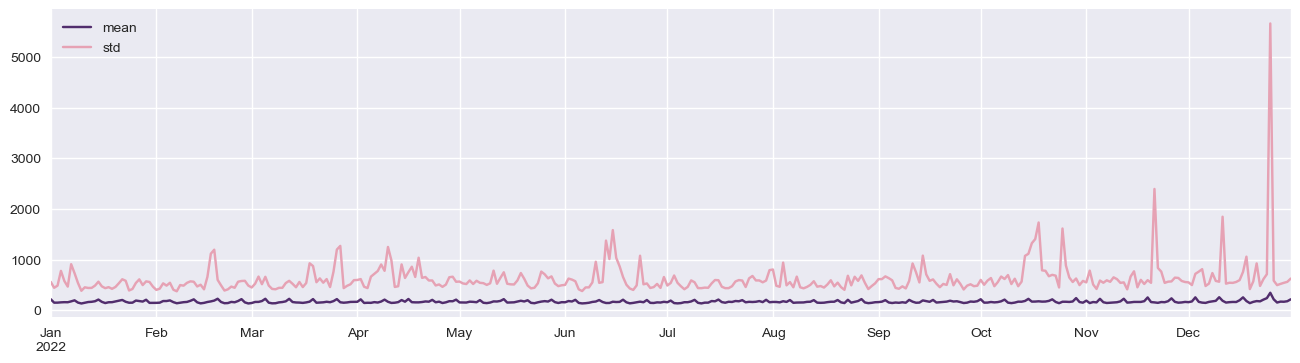

In [21]:
daily_distribution = pd.DataFrame([], columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']) 
date_range = pd.date_range(start="2021-01-01",end="2022-12-31")

for d in date_range:
    df_day = df.loc[df['DATE_DIM'] == d, 'TOTAL_TURNOVER']
    dis = df_day.describe().to_frame().transpose()
    
    daily_distribution = daily_distribution.append(dis)
    
daily_distribution.index = date_range

daily_distribution.loc[daily_distribution.index.year==2022  ,['mean', 'std']].plot();

### a. RACING vs SPORT and FOB vs PARI  <a name="III.2.a"></a>

Western Australia TAB is primarily a racing wagering company, sport betting is considered a side category. Therefore, we will see that the trend of racing turnover will overwhelm the other. The gap is not as drastic for FOB vs. PARI.

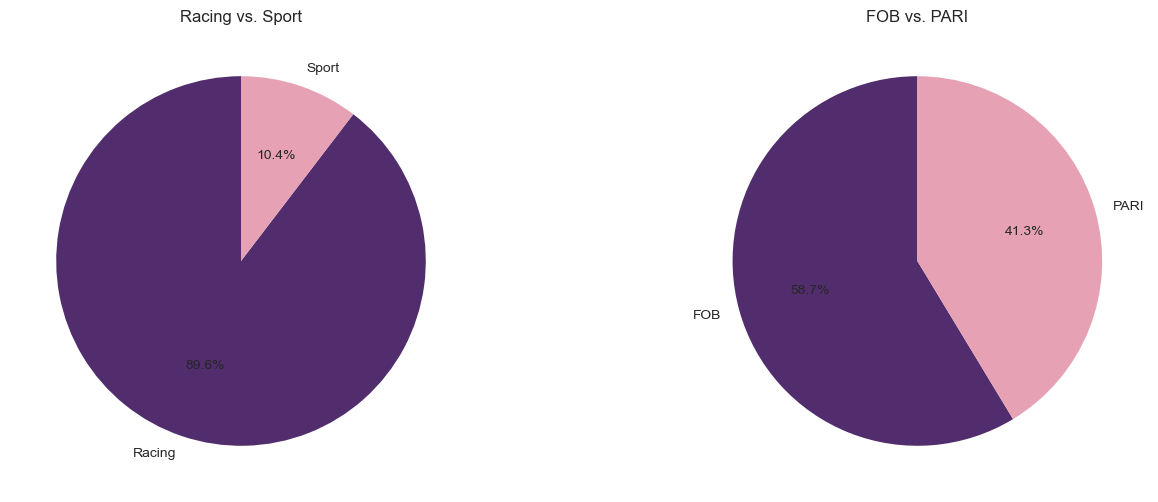

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

ax[0].pie(df[['RACING_TURNOVER', 'SPORT_TURNOVER']].sum(axis=0), labels= ["Racing", 'Sport'], autopct='%1.1f%%', startangle=90)
ax[0].set_title('Racing vs. Sport')

ax[1].pie(df[['FOB_TURNOVER', 'PARI_TURNOVER']].sum(axis=0), labels= ["FOB", 'PARI'], autopct='%1.1f%%', startangle=90)
ax[1].set_title('FOB vs. PARI')

plt.show();

### b. Trends <a name="III.2.b"></a>

We can explore the daily total turnover and identify trends.

#### Aggregate <a name="III.2.b.1"></a>

In [23]:
# Aggregate by day
df_agg = df.set_index('DATE_DIM').resample('d')[['RACING_TURNOVER', 'SPORT_TURNOVER', 'FOB_TURNOVER', 'PARI_TURNOVER', 
                                                 'TOTAL_TURNOVER', 'DIVIDENDS_PAID', 'GROSS_MARGIN', 'TICKETS']].sum()

# Preview
df_agg.head()

,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
DATE_DIM,,,,,,,,
2021-01-01,3675463.56,160299.45,1900648.00,1935115.01,3835763.01,3114833.37,612209.61,488284
2021-01-02,5908319.48,257615.55,3587422.50,2578512.53,6165935.03,4950837.44,1108786.73,698304
2021-01-03,1866557.48,331455.71,1262085.50,935927.69,2198013.19,1826858.93,329320.26,280706
2021-01-04,1201729.24,321883.43,908516.50,615096.17,1523612.67,1287301.59,199908.63,194321
2021-01-05,1255772.61,225060.21,827286.50,653546.32,1480832.82,1213781.16,251753.98,201566


#### 2021 vs 2022 trend <a name="III.2.b.2"></a>

In [24]:
# 2021 vs 2022
df_agg_2021 = df_agg[df_agg.index.year == 2021]
df_agg_2022 = df_agg[df_agg.index.year == 2022]

print("Total turnover in 2021 : ", df_agg_2021['TOTAL_TURNOVER'].sum())
print("Total turnover in 2022 : ", df_agg_2022['TOTAL_TURNOVER'].sum())

Total turnover in 2021 :  1103904371.1399999
Total turnover in 2022 :  1090985007.02


The turnover trend is pretty consistent throughout the year with bottoming on Monday and peaking on Saturday. This is perfectly suitable for time series models like Exponential Smoothing.

There is no sudden upward or downward movement except two anomalies:
- Peak: Melbourne Cup, first Tuesday of November
- Bottom: Christmas day, the company closes racing wagering on 12-25 every year
We have to factor these outliers into the model

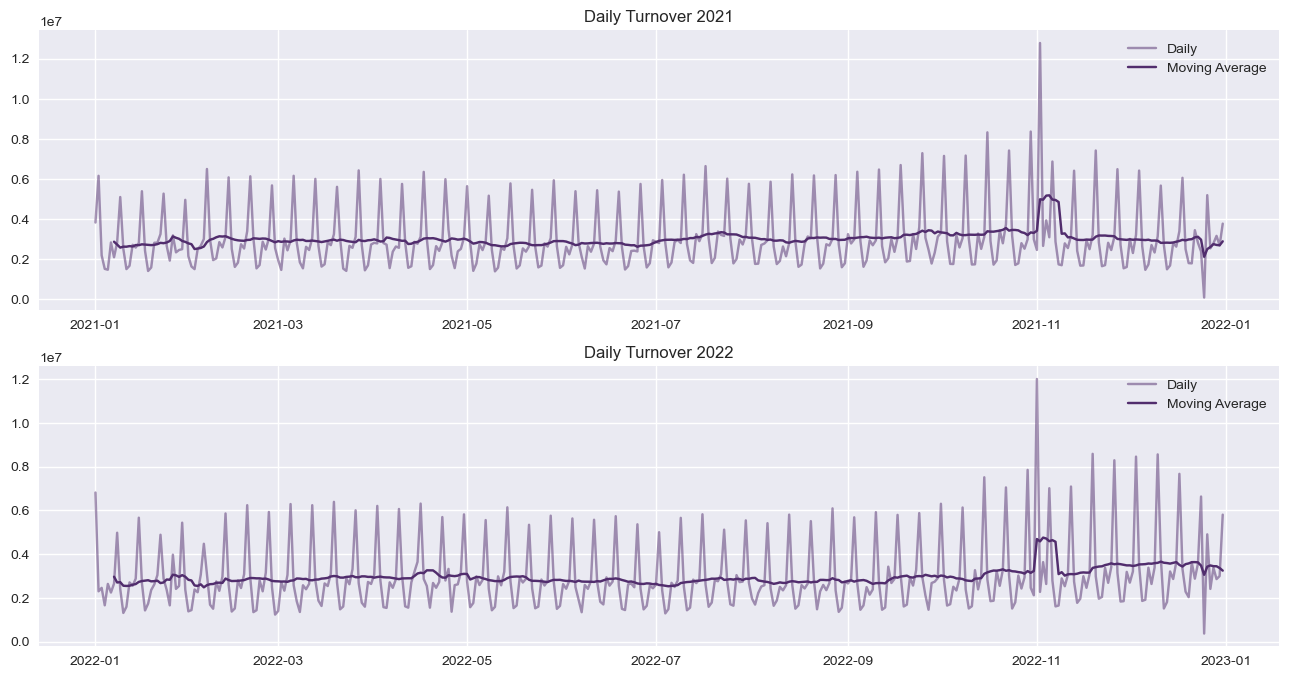

In [25]:
# 7 day moving average
df_agg_rolling_2021 = df_agg_2021['TOTAL_TURNOVER'].rolling(window=7).mean()
df_agg_rolling_2022 = df_agg_2022['TOTAL_TURNOVER'].rolling(window=7).mean()

# Visualize
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2021['TOTAL_TURNOVER'], color="#512d6d", alpha=0.5, label = 'Daily')
ax[0].plot(df_agg_rolling_2021, label='Moving Average')
ax[0].legend()
ax[0].set_title('Daily Turnover 2021')

ax[1].plot(df_agg_2022['TOTAL_TURNOVER'], color="#512d6d", alpha=0.5, label = 'Daily')
ax[1].plot(df_agg_rolling_2022, label='Moving Average')
ax[1].legend()
ax[1].set_title('Daily Turnover 2022')

plt.show()

To see the parttern clearer, we can plot a weekly average

Text(0.5, 1.0, 'Weekly average turnover')

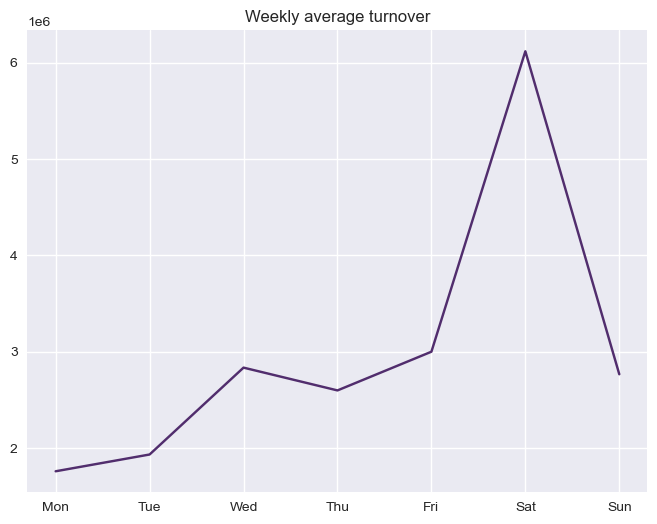

In [26]:
df_weekly = df_agg.groupby(df_agg.index.weekday).TOTAL_TURNOVER.mean()
df_weekly.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Visualize
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(df_weekly)
ax.set_title("Weekly average turnover")

<b>By now, we can safely presume the trends in 2022 and 2021 are parallel. We decide to choose 2022 as the year to focus on to obtain more insights of a yearly trend.

#### Racing vs Sport <a name="III.2.b.3"></a>

As can seen in the plots, the two patterns are distinct. Racing trend is more similar to the overall trend because it accounts for 90% of the total turnover. The line flucuantes much more with sport turnover but we can spot a surge from March to September. That is the Australian Football League season starting on 2022-03-16 and finalizing on 2022-09-24.

With two much dissimilar trends, we can create two exponential smoothing models then aggregate the predicted values. It is the way we can customize and factor in these outliers.

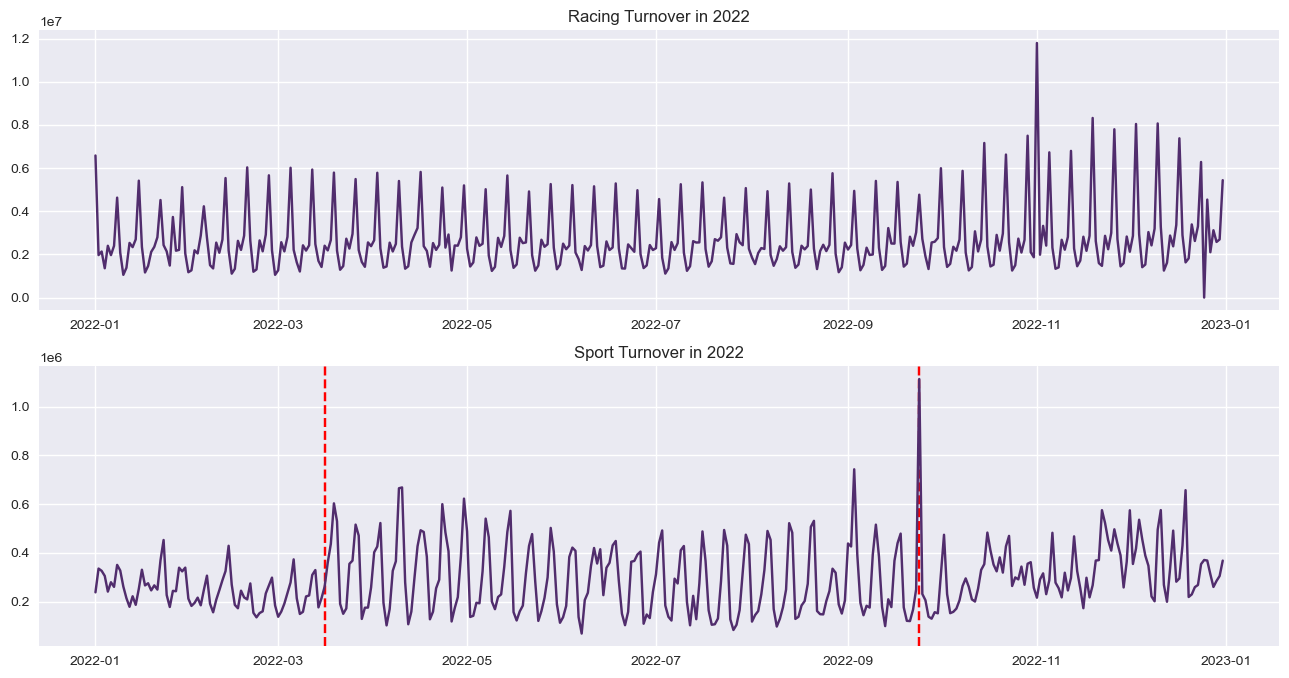

In [20]:
fig, ax = plt.subplots(2, figsize=(16,8))

ax[0].plot(df_agg_2022['RACING_TURNOVER'])
ax[0].set_title('Racing Turnover in 2022')

threshold_1 = datetime(2022, 3, 16)
threshold_2 = datetime(2022, 9, 24)
threshold_mpl_1 = mdates.date2num(threshold_1)
threshold_mpl_2 = mdates.date2num(threshold_2)

ax[1].axvline(threshold_mpl_1 , color='red', linestyle='--')
ax[1].axvline(threshold_mpl_2 , color='red', linestyle='--')

ax[1].plot(df_agg_2022['SPORT_TURNOVER'])
ax[1].set_title('Sport Turnover in 2022')

plt.show()

#### Average ticket value <a name="III.2.b.4"></a>

Average ticket value stays consistent throughout the year except the Christmas day. 

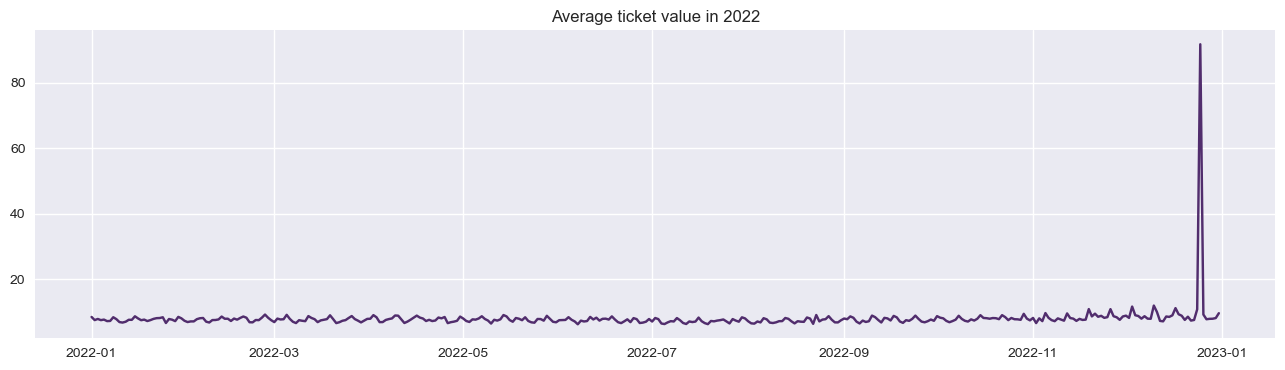

In [23]:
df_avg = df_agg_2022['TOTAL_TURNOVER'] / df_agg_2022['TICKETS']

# Visualize
fig, ax = plt.subplots(1, figsize=(16,4))
ax.plot(df_avg)
plt.title("Average ticket value in 2022")
plt.show()

#### Average daily turnover per customer <a name="III.2.b.5"></a>

The interesting is that the average spending isn't affected much by the Melbourn Cup finale event. It approves just more people wager on that day or the low bets balance the average.

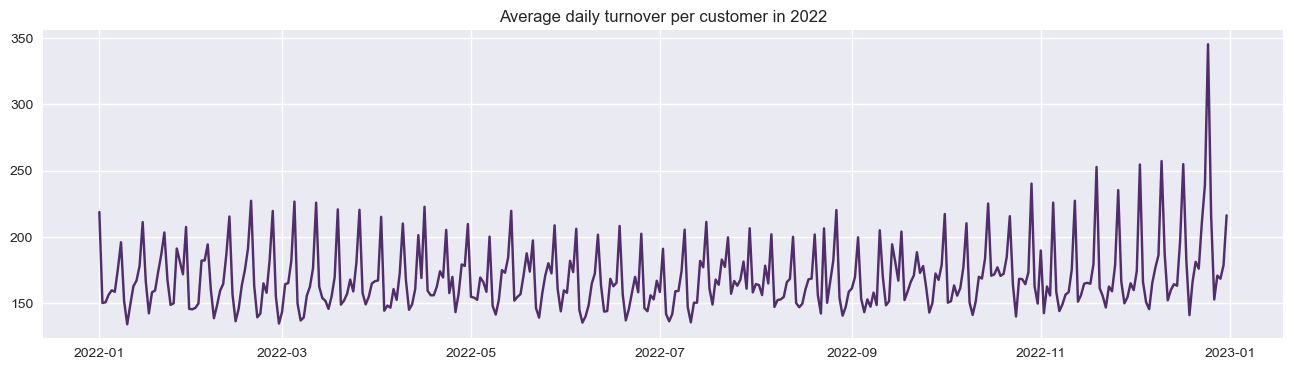

In [30]:
df_cus = df.loc[df['DATE_DIM'].dt.year == 2022, ['DATE_DIM','BET_ACCOUNT_NUM_HASH']].set_index('DATE_DIM').resample('d').BET_ACCOUNT_NUM_HASH.count()

df_avg = df_agg_2022['TOTAL_TURNOVER'] / df_cus

# Visualize
fig, ax = plt.subplots(1, figsize=(16,4))
ax.plot(df_avg)
plt.title("Average daily turnover per customer in 2022")
plt.show()

### c. Correlation with other factors <a name="III.2.c"></a>

#### Correlation matrix  <a name="III.2.c.1"></a>

We can see that other features (`DIVIDENDS_PAID`,`GROSS_MARGIN`,`TICKETS`... ) heavily correlate with TOTAL_TURNOVER. `SPORT_TURNOVER` can vary drastically. It lines up with our analysis above.

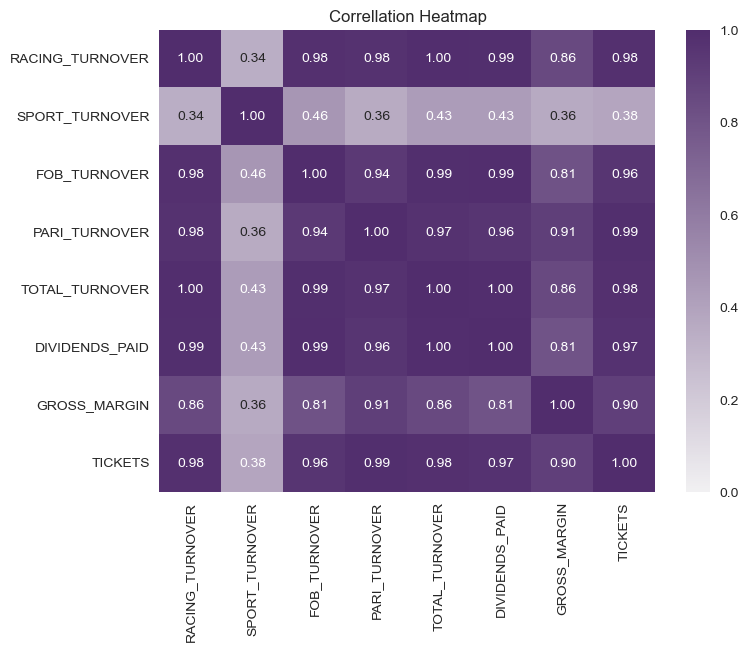

In [31]:
# Correlation maxtrix
df_corr = df_agg.corr()

plt.figure(figsize=(8,6))

cmap = sns.light_palette("#512d6d", as_cmap=True)
sns.heatmap(df_corr, cmap=cmap, vmin=0, vmax=1 , annot=True, fmt=".2f")
plt.title("Correllation Heatmap")

plt.plot();

#### Dividends paid / total turnover <a name="III.2.c.2"></a>

The ratio stays consistently above 80% throughout the year 2022.

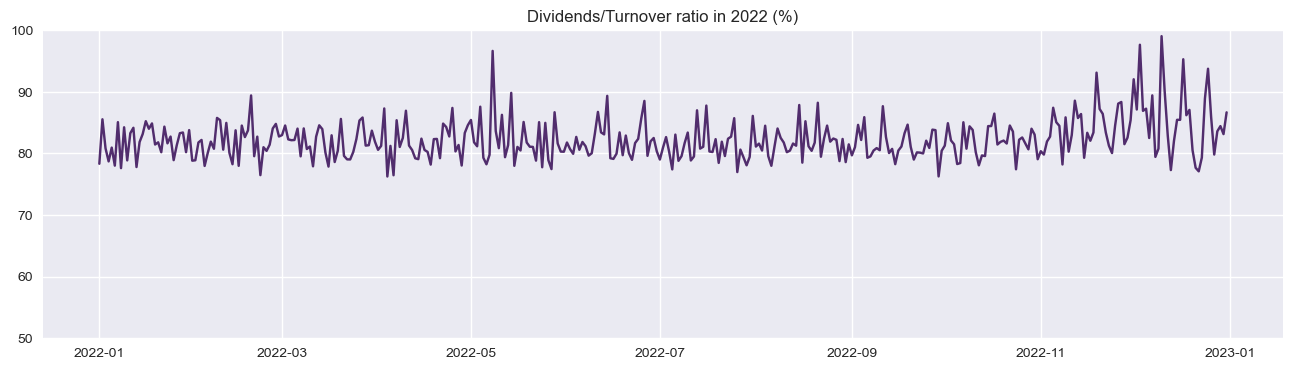

In [32]:
df_div_per =  df_agg_2022['DIVIDENDS_PAID'] / df_agg_2022['TOTAL_TURNOVER'] * 100

# Visulize
fig, ax = plt.subplots(1, figsize=(16,4))

ax.plot(df_div_per)
ax.set_ylim((50,100))
ax.set_title("Dividends/Turnover ratio in 2022 (%)")
plt.show()

#### FOB vs PARI <a name="III.2.c.3"></a>

FOB / Total turnover ratio stays at 60% consistently throughout the year.

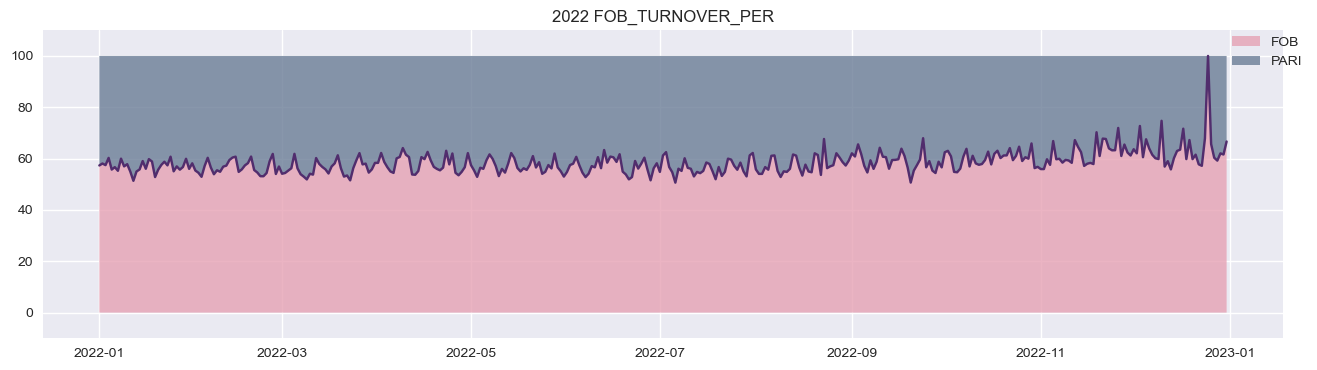

In [33]:
## 2022: FOB vs PARI 
fig, ax = plt.subplots(1, figsize=(16,4))
df_agg_2022['FOB_TURNOVER_PER'] = df_agg_2022['FOB_TURNOVER'] / df_agg_2022['TOTAL_TURNOVER'] * 100
df_agg_2022['PARI_TURNOVER_PER'] = 100 - df_agg_2022['FOB_TURNOVER_PER']

# Visualize
ax.plot(df_agg_2022['FOB_TURNOVER_PER'])
plt.stackplot(df_agg_2022.index, df_agg_2022['FOB_TURNOVER_PER'], df_agg_2022['PARI_TURNOVER_PER'], labels=['FOB', 'PARI'], alpha=0.8)

ax.set_title('2022 FOB / PARI Ratio')
ax.legend(loc='best', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax.set_ylim(-10,110)

plt.show()

## 3. Customer <a name="III.3"></a>

In [51]:
# Aggregate data
cus_df = df.groupby('BET_ACCOUNT_NUM_HASH', as_index=False) \
            .agg({'AGE': max, 
                  'GENDER': max,
                  'TENURE_IN_DAYS' : max,
                  'RESIDENTIAL_STATE' : min, 
                  'DATE_DIM': [min, max, np.size],
                  'RACING_TURNOVER' : sum, 
                  'SPORT_TURNOVER' : sum, 
                  'FOB_TURNOVER' : sum, 
                  'PARI_TURNOVER' : sum, 
                  'TOTAL_TURNOVER' : sum, 
                  'DIVIDENDS_PAID' : sum,
                  'GROSS_MARGIN' : sum, 
                  'TICKETS' : sum})

# Rename columns
cus_df.columns = ["_".join(x).upper() if x[0] == "DATE_DIM" else x[0] for x in cus_df.columns.ravel() ]

cus_df.head()

,BET_ACCOUNT_NUM_HASH,AGE,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,DATE_DIM_MIN,DATE_DIM_MAX,DATE_DIM_SIZE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,13154,67.00,M,12575,WA,2021-01-01,2022-12-31,463,366186.08,0.00,31113.00,335073.08,366186.08,270817.07,81925.97,113627
1,18379,54.00,M,2613,WA,2021-01-01,2022-12-31,195,31934.00,99.00,28021.00,4012.00,32033.00,23658.86,6645.73,836
2,37251,22.00,U,0,WA,2022-11-01,2022-11-01,1,100.00,0.00,65.00,35.00,100.00,760.00,-689.65,7
3,129273,22.00,U,358,WA,2021-12-26,2022-12-19,16,62.00,93.00,155.00,0.00,155.00,149.45,5.55,37
4,348318,29.00,U,106,WA,2022-06-10,2022-09-24,4,25.00,5.00,27.00,3.00,30.00,0.00,27.58,17


### a. General info <a name="III.3.a"></a>

#### Describe <a name="III.3.a.1"></a>

In [41]:
cus_df.describe()

,AGE,TENURE_IN_DAYS,DATE_DIM_SIZE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
count,144829.00,144829.00,144829.00,144829.00,144829.00,144829.00,144829.00,144829.00,144829.00,144829.00,144829.00
mean,43.68,1658.13,85.07,13580.05,1574.99,8890.05,6265.00,15155.04,12526.39,2366.23,1888.17
std,15.92,2442.74,141.77,55657.38,22393.03,47379.30,28987.38,61888.95,54217.37,9367.01,8883.14
min,18.00,-1.00,1.00,0.00,0.00,0.00,0.00,0.50,0.00,-327327.36,1.00
25%,31.00,2.00,3.00,100.00,0.00,75.00,11.00,163.00,73.50,20.00,17.00
50%,41.00,787.00,18.00,723.50,5.00,492.00,138.00,993.00,738.80,150.00,101.00
75%,55.00,2227.00,97.00,5969.02,139.00,3606.55,1494.00,7074.53,5905.70,1061.14,700.00
max,104.00,20600.00,730.00,5234120.84,2849523.33,4399559.00,3599772.50,5544861.46,4507251.65,467391.88,699955.00


#### Unique customers <a name="III.3.a.2"></a>

In [15]:
print("Total unique customers : ", cus_df.shape[0])
print("Total unique customers in 2021 : ", df.loc[df['DATE_DIM'].dt.year == 2021, 'BET_ACCOUNT_NUM_HASH'].nunique())
print("Total unique customers in 2022 : ", df.loc[df['DATE_DIM'].dt.year == 2022, 'BET_ACCOUNT_NUM_HASH'].nunique())

Total unique customers :  144829
Total unique customers in 2021 :  110497
Total unique customers in 2022 :  116456


#### Daily unique customers <a name="III.3.a.3"></a>

The amount of customers per week almost never change except for 2 contextual outlier points we discussed above

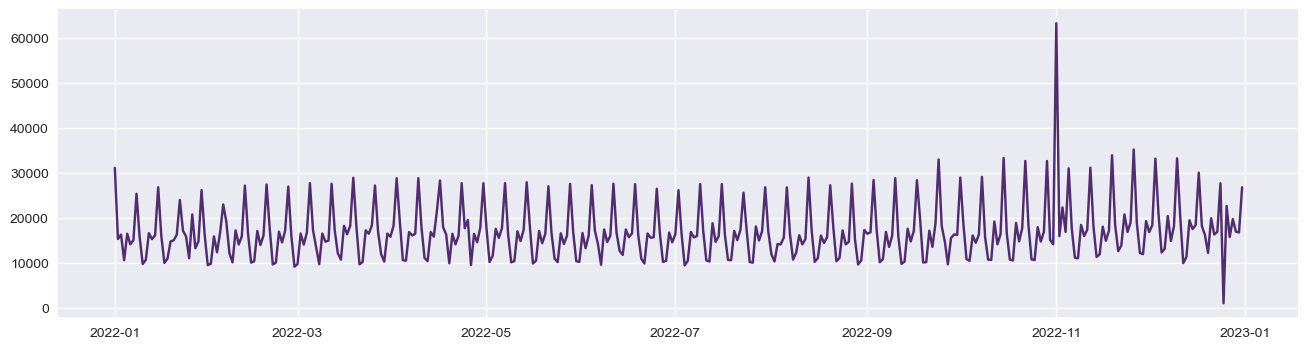

In [34]:
cus_num_df = df.set_index('DATE_DIM').resample('d').BET_ACCOUNT_NUM_HASH.size()

plt.figure(figsize=(16,4))
plt.plot(cus_num_df[365:])
plt.title("Daily total unique customers in 2022")

#### New customers <a name="III.3.a.4"></a>

Daily brand new customers are minimal compared to the total. Most of the current wagering customers are old customers.

Text(0.5, 1.0, 'Daily new customers in 2022')

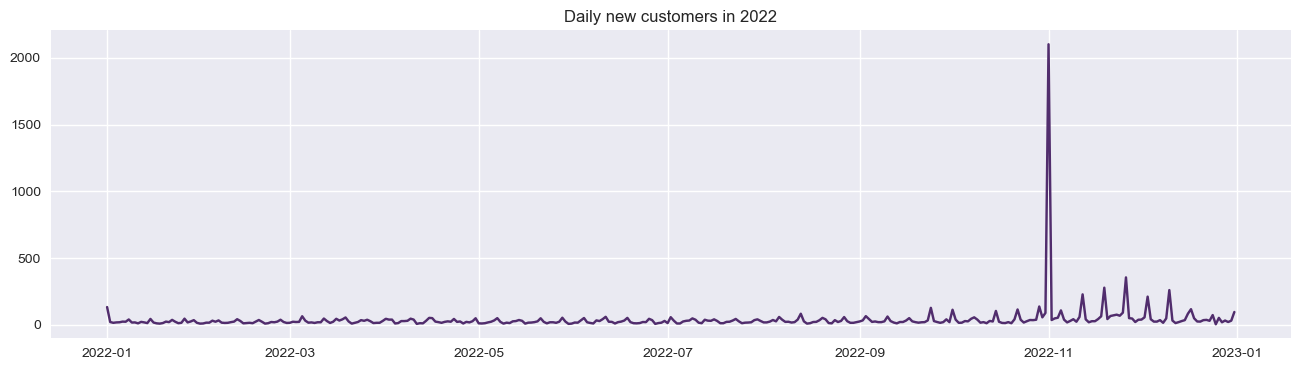

In [38]:
new_cus_df = df[df['TENURE_IN_DAYS'] == 0 ].groupby('BET_ACCOUNT_NUM_HASH', as_index=False).agg({'DATE_DIM' : min})
new_cus_df = new_cus_df.set_index('DATE_DIM').resample('d').BET_ACCOUNT_NUM_HASH.size()

plt.figure(figsize=(16,4))
plt.plot(new_cus_df[365:])
plt.title("Daily new customers in 2022")

### b. Demographic info <a name="III.3.b"></a>

#### Gender <a name="III.3.b.1"></a>

'U' (unidentified) data comprise the majority of gender. It's most likely missing data, therefore this factor might not be usable in the model. However, we can say the demo is predominantly male.

In [44]:
cus_gender_df = cus_df.groupby('GENDER').agg({'BET_ACCOUNT_NUM_HASH': "count", 'TOTAL_TURNOVER': "sum"})
cus_gender_df['AVERAGE_TURNOVER'] = cus_gender_df.TOTAL_TURNOVER / cus_gender_df.BET_ACCOUNT_NUM_HASH * 100
cus_gender_df

,BET_ACCOUNT_NUM_HASH,TOTAL_TURNOVER,AVERAGE_TURNOVER
GENDER,,,
F,13918,189064996.89,1358420.73
M,49718,1469620065.80,2955911.47
U,81193,536204315.47,660407.07


#### Residential state <a name="III.3.b.2"></a>

In [45]:
cus_state_df = cus_df.groupby('RESIDENTIAL_STATE').agg({'BET_ACCOUNT_NUM_HASH': "count", 'TOTAL_TURNOVER': "sum"})
cus_state_df['AVERAGE_TURNOVER'] = cus_state_df.TOTAL_TURNOVER / cus_state_df.BET_ACCOUNT_NUM_HASH * 100
cus_state_df

,BET_ACCOUNT_NUM_HASH,TOTAL_TURNOVER,AVERAGE_TURNOVER
RESIDENTIAL_STATE,,,
OTH,26283,317727955.30,1208872.49
WA,118546,1877161422.86,1583487.78


#### Age <a name="III.3.b.3"></a>

The distribution is pretty normal with a right tail. Most customers are in 30-45 age range.

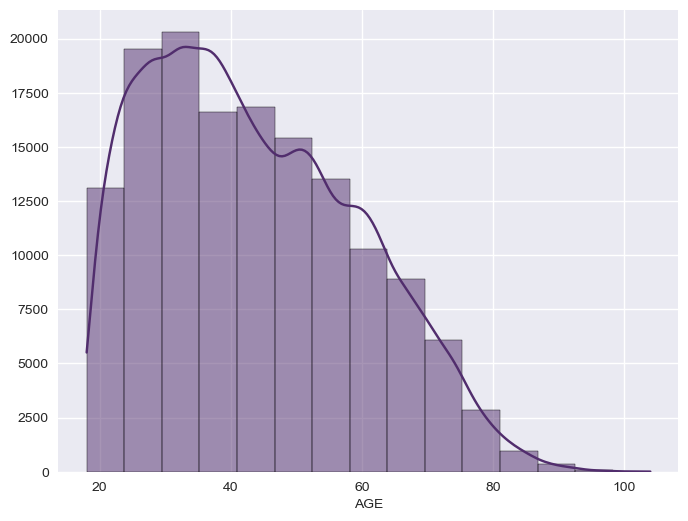

In [49]:
# Age distribution
plt.figure(figsize=(8,6))
sns.histplot(cus_df['AGE'], kde=True, bins=15)
plt.ylabel("")

plt.show();

It is recommended to categorize age in different groups and create dummy variables based on the discrete factor rather than using the continuous variable. It appears the older the customer is, the more they spend.

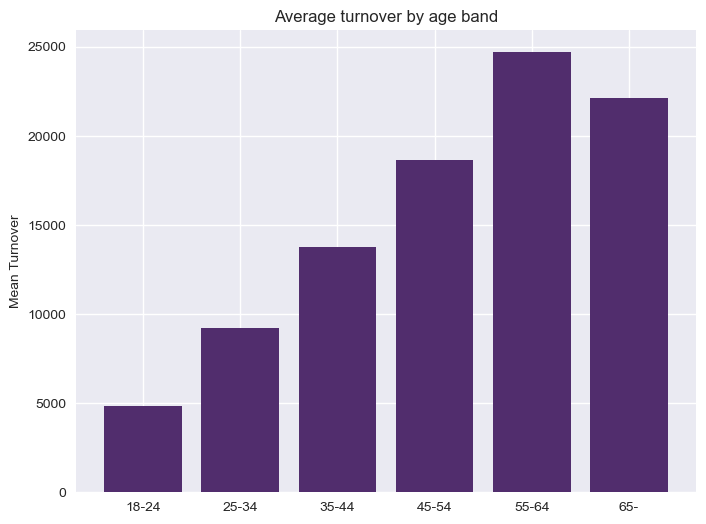

In [48]:
bins = [18,25,35,45,55,65, np.inf]
cus_df['AGE_BAND'] = pd.cut(cus_df['AGE'], right=False, bins=bins)

cus_age_df = cus_df.groupby('AGE_BAND').TOTAL_TURNOVER.mean()

fig, ax = plt.subplots(1, figsize=(8,6))

ax.bar(["18-24", "25-34", "35-44", "45-54", "55-64", "65-"], cus_age_df)
ax.set_ylabel("Mean Turnover")
ax.set_title("Average turnover by age band")

# Display the chart
plt.show()

#### Tenure in days <a name="III.3.b.4"></a>

Most of the active customers of the past 2 years are senior customers (over 3 years)

Mean :  5.522554184590103
Median :  3.0


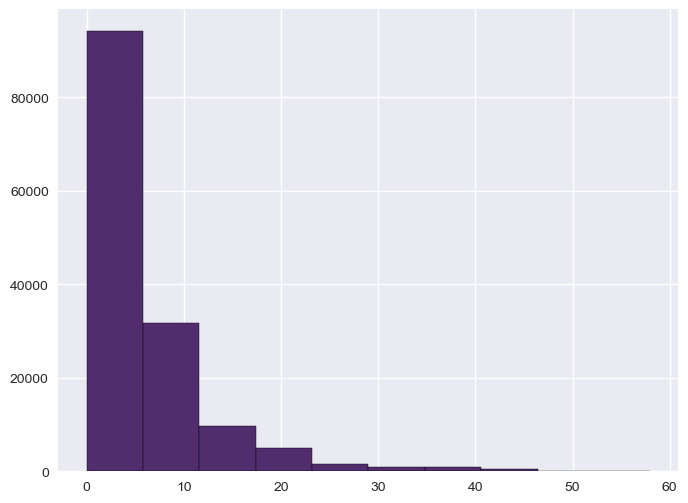

In [82]:
# Create 'SENORITY' column indicating the number of years as customer since sign-up date until 2022-12-31
cus_df['SENORITY'] = np.floor(((datetime(2022,12,31) - cus_df['DATE_DIM_MAX']).dt.days  + cus_df['TENURE_IN_DAYS'])/365)

# Averages
print("Mean : ", cus_df['SENORITY'].mean())
print("Median : ", cus_df['SENORITY'].median())

# Visulize
plt.figure(figsize=(8,6))
plt.hist(cus_df['SENORITY'], edgecolor='black')
plt.show();

### c. Numerical data <a name="III.3.c"></a>

#### Correlation matrix <a name="III.3.c.1"></a>

We will focus on turnover. Similar to analysis above, `TOTAL_TURNOVER` correlates heavily with `DIVIDENDS_PAID`, `GROSS_MARGIN`, `RACING_TURNOVER`. Other factors might be non-linearly related.

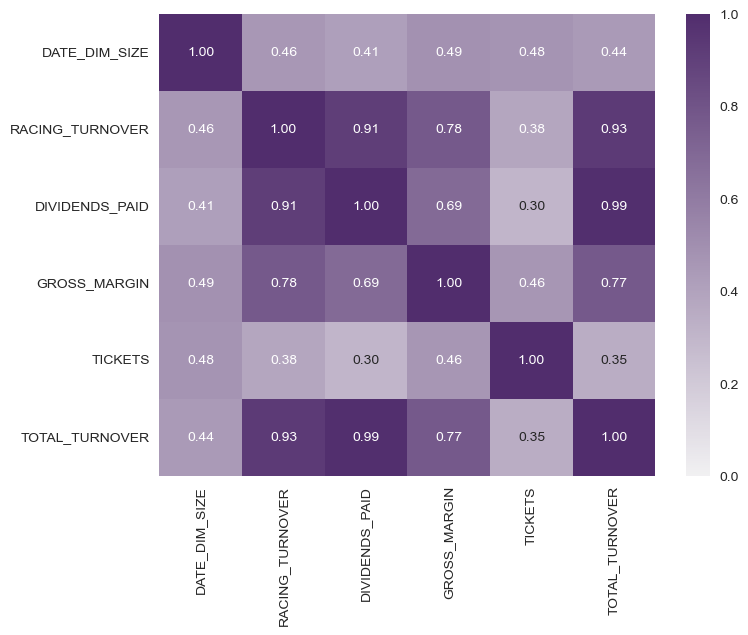

In [88]:
# Corrlation matrix
col_list = ['DATE_DIM_SIZE' , 'RACING_TURNOVER' , 'DIVIDENDS_PAID', 'GROSS_MARGIN' , 'TICKETS', 'TOTAL_TURNOVER']

cus_corr_df = cus_df[col_list].corr()

# Visualize
plt.figure(figsize=(8,6))
color = '#512d6d'
cmap = sns.light_palette("#512d6d", as_cmap=True)
sns.heatmap(cus_corr_df, cmap=cmap, vmin=0, vmax=1, annot=True, fmt=".2f")

plt.show()

#### Turnover <a name="III.3.c.2"></a>

We notice exponential decays with the distribution. Therefore, a log transformation would work great here to convert the distribution to Gaussian when modeling

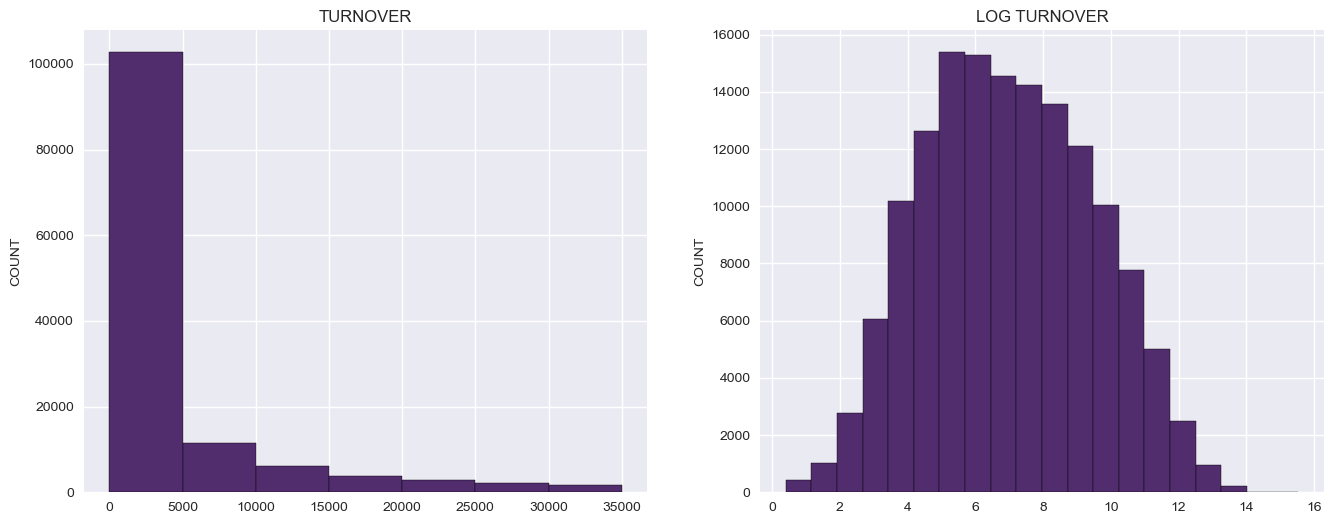

In [90]:
# TURNOVER and TICKETS
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].hist(cus_df['TOTAL_TURNOVER'], bins=range(0,40000, 5000), edgecolor='black')
ax[0].set_ylabel('COUNT')
ax[0].set_title('TURNOVER')

ax[1].hist(np.log(cus_df['TOTAL_TURNOVER']+1), bins=20, edgecolor='black')
ax[1].set_ylabel('COUNT')
ax[1].set_title('LOG TURNOVER')

plt.show();

#### Frequency vs Turnover <a name="III.3.c.3"></a>

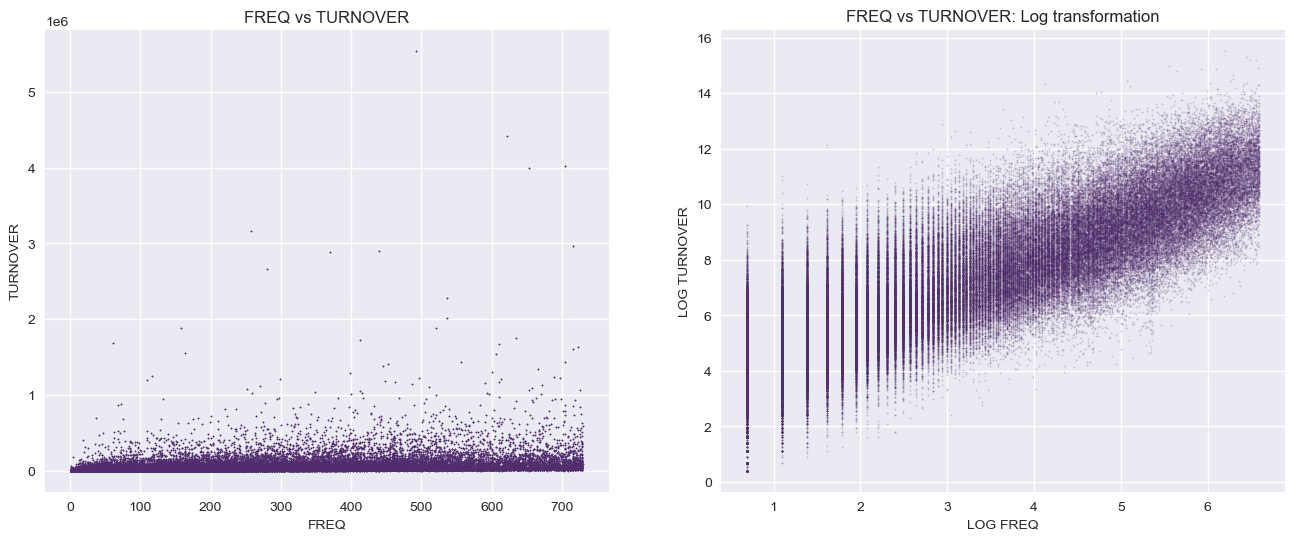

In [94]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].scatter(cus_df['DATE_DIM_SIZE'] , cus_df['TOTAL_TURNOVER'] , s=1)
ax[0].set_title('FREQ vs TURNOVER')
ax[0].set_xlabel('FREQ')
ax[0].set_ylabel('TURNOVER')

ax[1].scatter(np.log(cus_df['DATE_DIM_SIZE']+1) , np.log(cus_df['TOTAL_TURNOVER']+1) , s=1, alpha=0.2)
ax[1].set_title('FREQ vs TURNOVER: Log transformation')
ax[1].set_xlabel('LOG FREQ')
ax[1].set_ylabel('LOG TURNOVER')

plt.show()

#### Tickets vs Turnover <a name="III.3.c.4"></a>

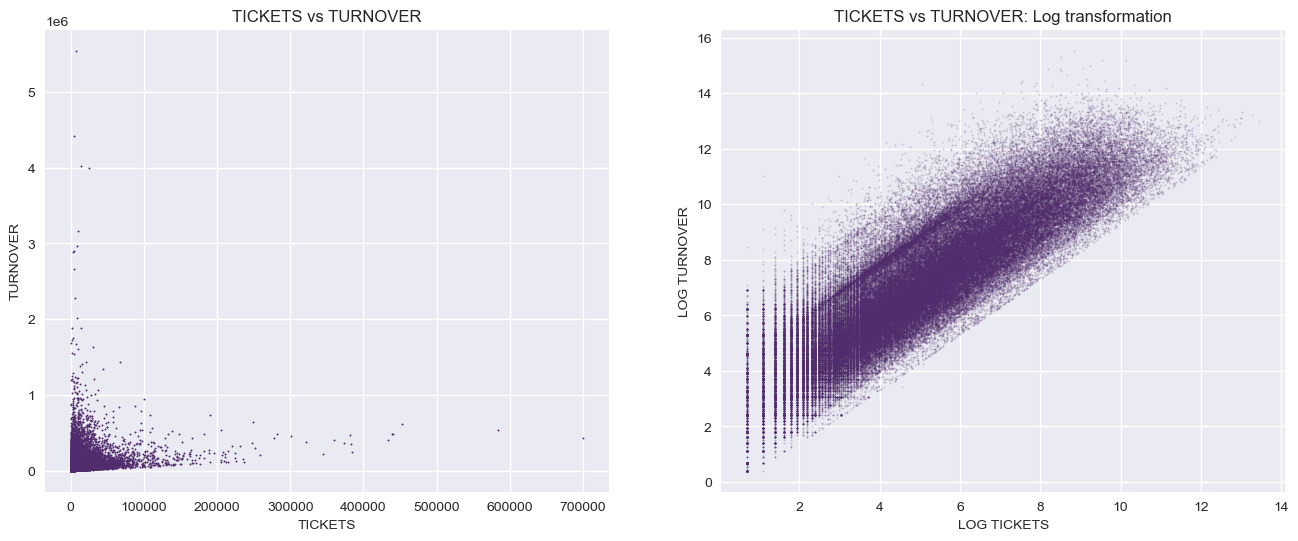

In [95]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].scatter(cus_df['TICKETS'] , cus_df['TOTAL_TURNOVER'] , s=1)
ax[0].set_title('TICKETS vs TURNOVER')
ax[0].set_xlabel('TICKETS')
ax[0].set_ylabel('TURNOVER')

ax[1].scatter(np.log(cus_df['TICKETS']+1) , np.log(cus_df['TOTAL_TURNOVER']+1) , s=1, alpha=0.2)
ax[1].set_title('TICKETS vs TURNOVER: Log transformation')
ax[1].set_xlabel('LOG TICKETS')
ax[1].set_ylabel('LOG TURNOVER')

plt.show()

#### Dividends, Margins vs Turnover <a name="III.3.c.5"></a>

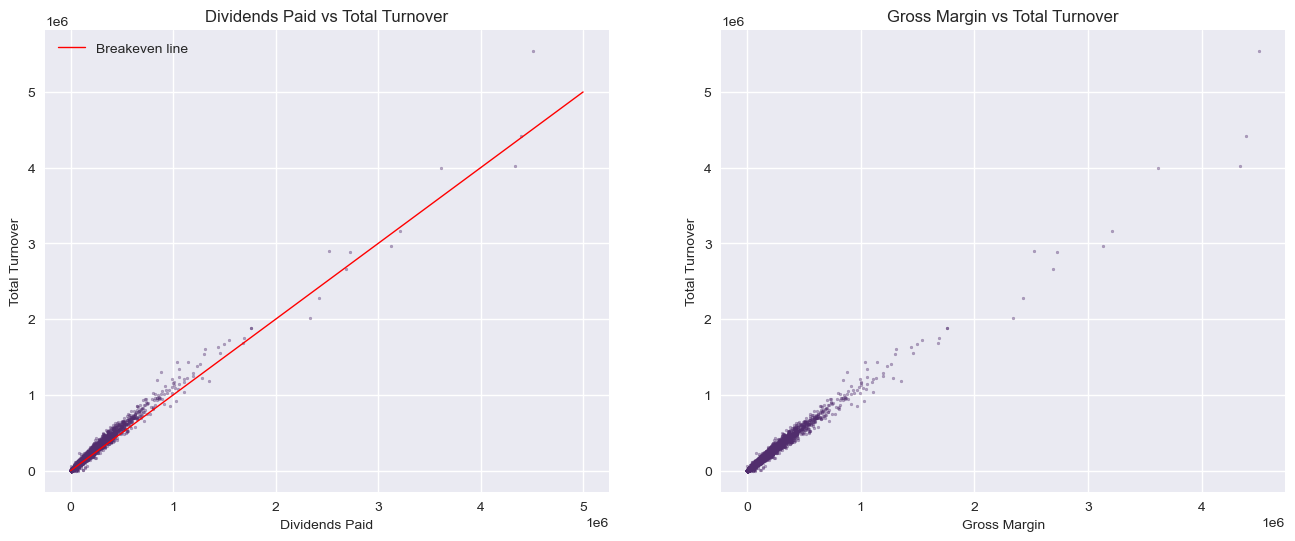

In [105]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

ax[0].scatter(cus_df['DIVIDENDS_PAID'], cus_df['TOTAL_TURNOVER'], s=4, alpha=0.4)
ax[0].plot([0, 5e6], [0, 5e6], linewidth=1, c='r', label="Breakeven line" )

ax[0].set_xlabel('Dividends Paid')
ax[0].set_ylabel('Total Turnover')
ax[0].set_title('Dividends Paid vs Total Turnover')
ax[0].legend()

ax[1].scatter(cus_df['DIVIDENDS_PAID'], cus_df['TOTAL_TURNOVER'], s=4, alpha=0.4)

ax[1].set_xlabel('Gross Margin')
ax[1].set_ylabel('Total Turnover')
ax[1].set_title('Gross Margin vs Total Turnover')

plt.show();

`DIVIDENDS_PAID` almost completely linearly correlate with `TOTAL_TURNOVER`. This means there is almost no devastating loss. `GROSS_MARGIN` has a considerably strong correlation with `TURNOVER` too. 

I might seem that the more you invest, the bigger you win. That's only half of the story. The red line indicates the break even boundary. We have to analyze the variance to truly understand the risk.